<a href="https://colab.research.google.com/github/thabied/Solar-Energy-Antwerp/blob/master/Solar_Energy_in_Belgium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LOAD PACKAGE REQUIREMENTS**

In [ ]:
!pip install pycaret

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from xgboost import Booster
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, GridSearchCV, RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **FEATURE ENGINEERING**

In [ ]:
solar = pd.read_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/solarpower_cumuldaybyday2.csv')
weather = pd.read_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/weather_in_Antwerp.csv')
electricity = pd.read_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/PV_Elec_Gas2.csv')

In [ ]:
# SPLIT DATETIME INTO YEAR, MONTH AND DAY
electricity['Unnamed: 0'] = pd.to_datetime(electricity['Unnamed: 0'])
electricity.set_index('Unnamed: 0',inplace=True)

electricity['year'] = electricity.index.year
electricity['month'] = electricity.index.month
electricity['day'] = electricity.index.day

electricity.reset_index(inplace=True)
electricity = electricity[['year','month','day','cum_power','Elec_kW','Gas_mxm']]

In [ ]:
# SHIFT ALL READINGS BACK ONE DAY BECAUSE MEASUREMENTS WERE TAKEN IN THE MORNING REFLECTING THE PREVIOUS DAYS MEASUREMENTS AND READINGS
electricity['day'] = electricity['day'] - 1

for i in range(len(electricity)):
  if electricity['day'][i] == 0:
    electricity['month'][i] = electricity['month'][i] - 1
    if electricity['month'][i] in [1,3,5,7,8,10,12]:
      electricity['day'][i] = electricity['day'][i] + 31
    elif electricity['month'][i] in [4,6,9,11]:
      electricity['day'][i] = electricity['day'][i] + 30
    elif electricity['month'][i] in [2]:
      electricity['day'][i] = electricity['day'][i] + 28
    elif electricity['month'][i] == 0:
      electricity['month'][i] = electricity['month'][i] + 12
      electricity['year'][i] = electricity['month'][i] - 1

In [ ]:
# GENERATING DELTA COLUMN FROM CUMULATIVE ENERGY COLUMN
electricity['cum_powernew'] = electricity['cum_power'].diff()
electricity.drop('cum_power',axis=1,inplace=True)
electricity = electricity.rename(columns={'cum_powernew':'cum_power'})

In [ ]:
weather['temp'] = weather['temp'].astype(str)
weather['wind'] = weather['wind'].astype(str)
weather['humidity'] = weather['humidity'].astype(str)
weather['barometer'] = weather['barometer'].astype(str)
weather['visibility'] = weather['visibility'].astype(str)

In [ ]:
# REMOVE SYMBOLS FROM ENTRIES
for i in range(len(weather)):
  weather['temp'][i] = weather['temp'][i].replace('°C','')
for i in range(len(weather)):
  weather['wind'][i] = weather['wind'][i].replace(' km/h','')
for i in range(len(weather)):
  weather['humidity'][i] = weather['humidity'][i].replace('%','')
for i in range(len(weather)):
  weather['barometer'][i] = weather['barometer'][i].replace(' mbar','')
for i in range(len(weather)):
  weather['visibility'][i] = weather['visibility'][i].replace('km','')

In [ ]:
weather.to_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/weatherDF.csv')

In [ ]:
dfweather = pd.read_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/weatherDF.csv')

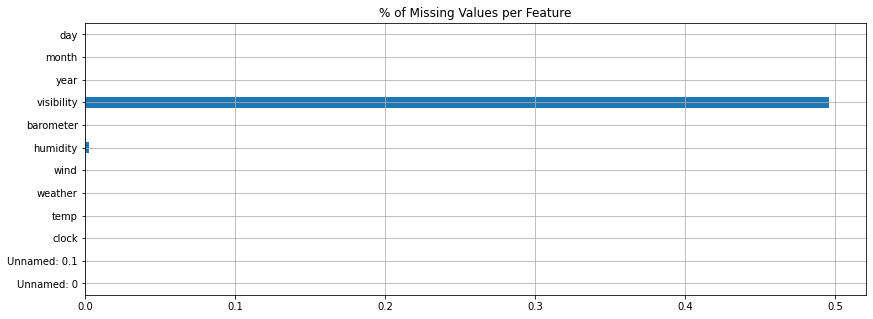

In [ ]:
missing_values = dfweather.isnull().sum() / len(dfweather)
missing_values.plot(kind='barh',figsize=(14,5),title='% of Missing Values per Feature',grid=True)

In [ ]:
dfweather.isnull().sum() / len(dfweather)

Unnamed: 0      0.000000
Unnamed: 0.1    0.000000
clock           0.000000
temp            0.000142
weather         0.000022
wind            0.000344
humidity        0.002603
barometer       0.000105
visibility      0.495844
year            0.000000
month           0.000000
day             0.000000
dtype: float64

In [ ]:
dfweather['wind'].replace(to_replace='No wind',value='0',inplace=True)

dfweather['temp'] = dfweather['temp'].astype(float)
dfweather['wind'] = dfweather['wind'].astype(float)
dfweather['visibility'] = dfweather['visibility'].astype(float)
dfweather['year'] = dfweather['year'].astype(int)
dfweather['month'] = dfweather['month'].astype(int)
dfweather['day'] = dfweather['day'].astype(int)

In [ ]:
# IMPUTE WITH MEAN VALUES
dfweather['temp'].fillna(dfweather['temp'].mean(),inplace=True)
dfweather['wind'].fillna(dfweather['wind'].mean(),inplace=True)
dfweather['humidity'].fillna(dfweather['humidity'].mean(),inplace=True)
dfweather['barometer'].fillna(dfweather['barometer'].mean(),inplace=True)
dfweather['visibility'].fillna(dfweather['visibility'].mean(),inplace=True)

In [ ]:
a = dfweather['weather'].unique()

In [ ]:
# LABELENCODE THE WEATHER FEATURE
dfweather['weather'] = dfweather['weather'].astype(str)

labelencoder = LabelEncoder()
dfweather['weather'] = labelencoder.fit_transform(dfweather['weather'])

In [ ]:
b = dfweather['weather'].unique()

In [ ]:
weathermap = np.array(list(zip(a,b)))

In [ ]:
print(weathermap)

In [ ]:
dfweather.to_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/weatherDF.csv')

In [ ]:
dfweather = pd.read_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/weatherDF.csv')

In [ ]:
# GROUPBY DAY TO MATCH THE ELECTRICITY DATASET
dfw = dfweather.groupby(['year','month','day']).mean().reset_index()
dfw.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1,inplace=True)

In [ ]:
electricity.drop(['Elec_kW','Gas_mxm'],axis=1,inplace=True)

In [ ]:
df = dfw.merge(electricity, on=['year','month','day'])

In [ ]:
df.to_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/dfnew.csv')

# **LOAD EDITED DATAFRAME**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/dfnew.csv',index_col=False)
df.drop(['Unnamed: 0'],axis=1,inplace=True)

# **EXPLORATORY DATA ANALYSIS**

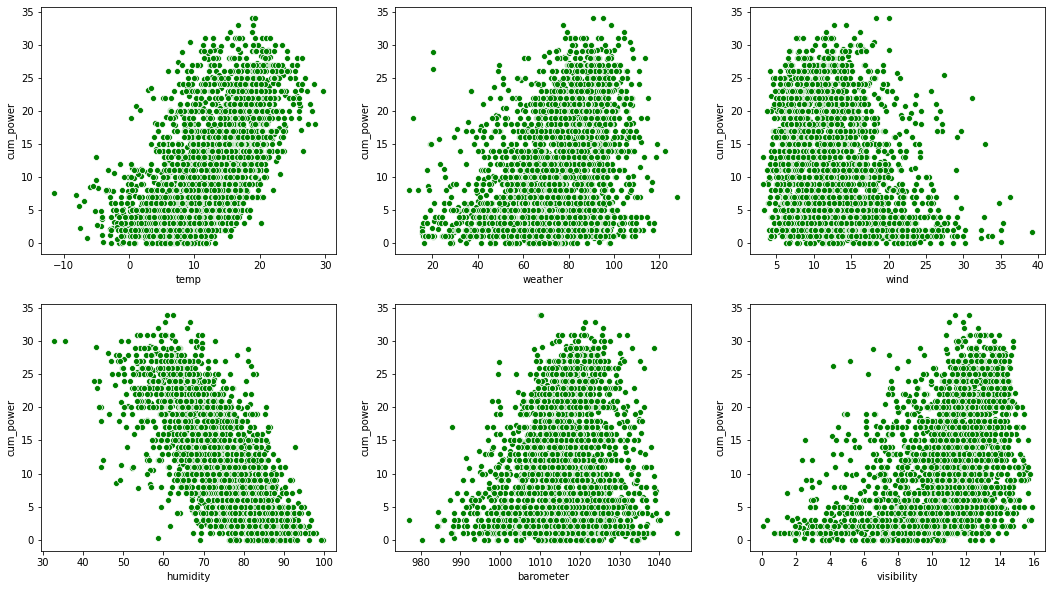

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(18,10))

sns.scatterplot(x='temp',y='cum_power',data=df,ax=ax[0,0],color='g')
sns.scatterplot(x='weather',y='cum_power',data=df,ax=ax[0,1],color='g')
sns.scatterplot(x='wind',y='cum_power',data=df,ax=ax[0,2],color='g')
sns.scatterplot(x='humidity',y='cum_power',data=df,ax=ax[1,0],color='g')
sns.scatterplot(x='barometer',y='cum_power',data=df,ax=ax[1,1],color='g')
sns.scatterplot(x='visibility',y='cum_power',data=df,ax=ax[1,2],color='g')

plt.show()

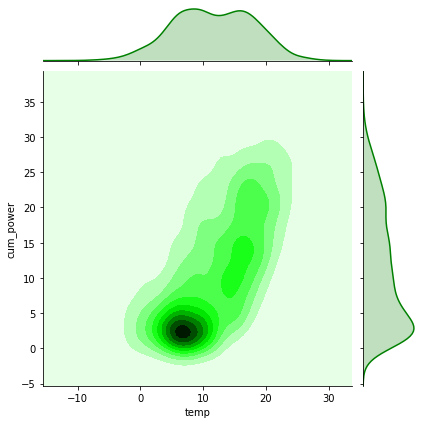

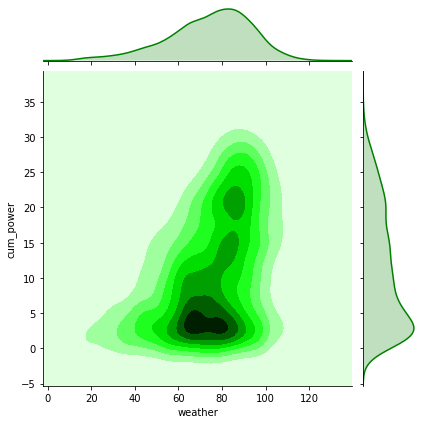

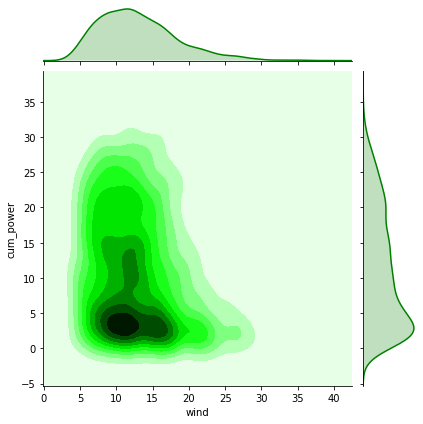

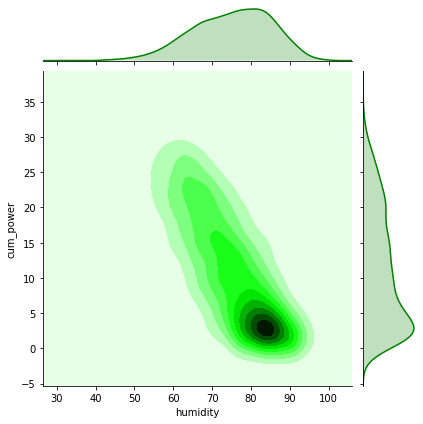

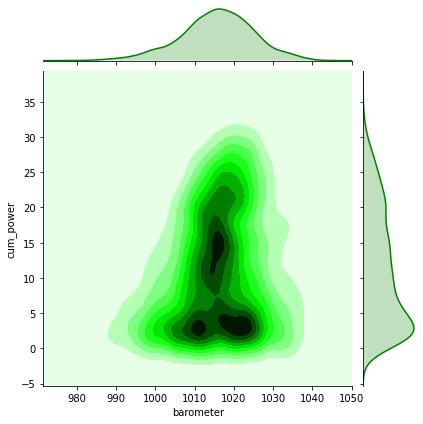

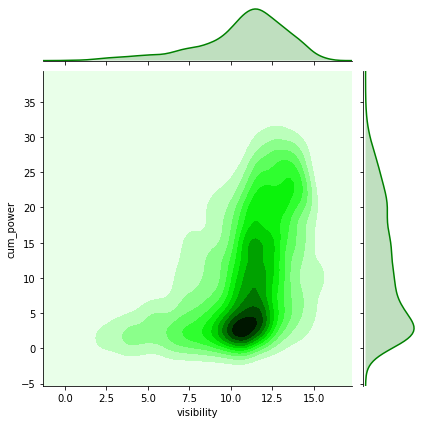

In [ ]:
a = sns.jointplot(x='temp',y='cum_power',data=df,kind='kde',color='g')
b = sns.jointplot(x='weather',y='cum_power',data=df,kind='kde',color='g')
c = sns.jointplot(x='wind',y='cum_power',data=df,kind='kde',color='g')
d = sns.jointplot(x='humidity',y='cum_power',data=df,kind='kde',color='g')
e = sns.jointplot(x='barometer',y='cum_power',data=df,kind='kde',color='g')
f = sns.jointplot(x='visibility',y='cum_power',data=df,kind='kde',color='g')

plots = [a,b,c,d,e,f]

for plot in plots:
  plt.plot()

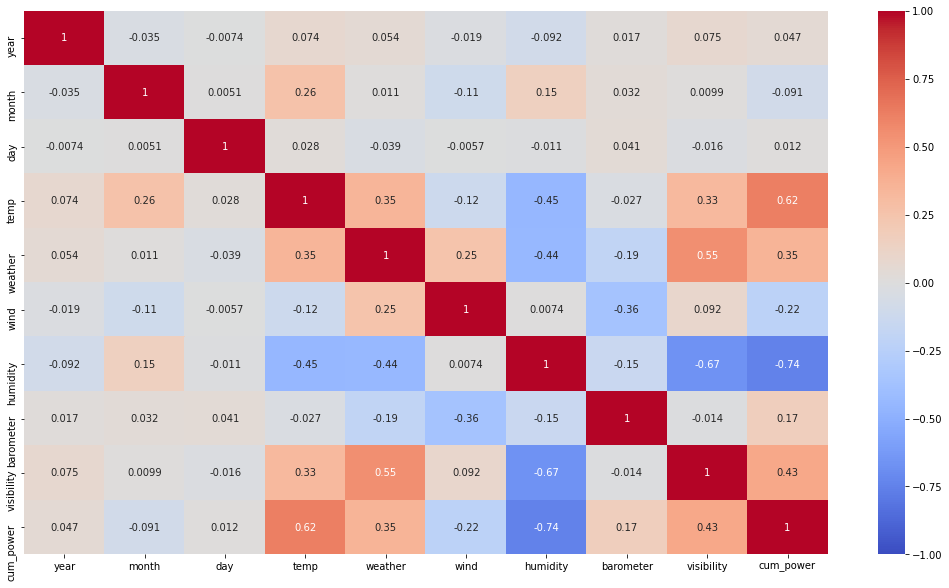

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

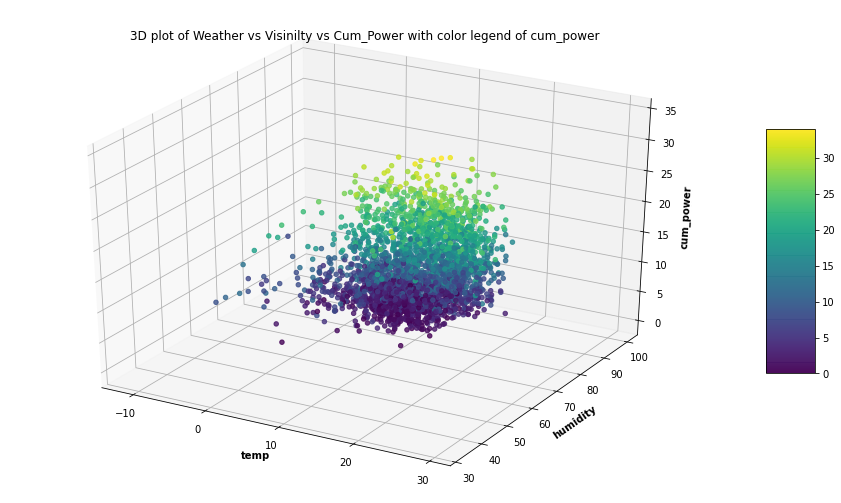

In [ ]:
# Creating figure 
fig = plt.figure(figsize = (16, 9)) 
ax = plt.axes(projection ="3d")

# Add x, y gridlines  
ax.grid(b = True, color ='grey',  
        linestyle ='-.', linewidth = 0.3,  
        alpha = 0.2)  
  
# Creating color map 
my_cmap = plt.get_cmap('hsv') 
  
# Creating plot 
sctt = ax.scatter3D(df['temp'], df['humidity'], df['cum_power'], 
                    alpha = 0.8, 
                    c = df['cum_power']) 
  
plt.title('3D plot of Weather vs Visinilty vs Cum_Power with color legend of cum_power') 
ax.set_xlabel('temp', fontweight ='bold')  
ax.set_ylabel('humidity', fontweight ='bold')  
ax.set_zlabel('cum_power', fontweight ='bold') 
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5) 
  
# show plot 
plt.show() 

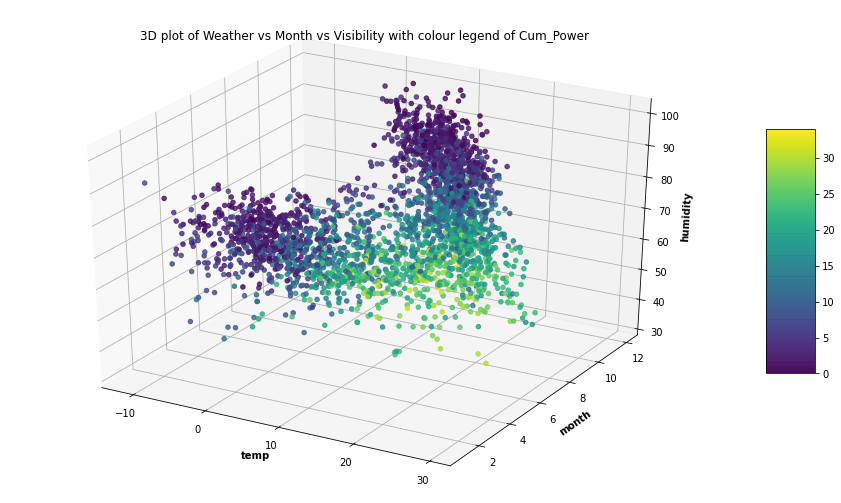

In [ ]:
# Creating figure 
fig = plt.figure(figsize = (16, 9)) 
ax = plt.axes(projection ="3d")

# Add x, y gridlines  
ax.grid(b = True, color ='grey',  
        linestyle ='-.', linewidth = 0.3,  
        alpha = 0.2)  
  
# Creating color map 
my_cmap = plt.get_cmap('hsv') 
  
# Creating plot 
sctt = ax.scatter3D(df['temp'], df['month'], df['humidity'], 
                    alpha = 0.8, 
                    c = df['cum_power']) 
  
plt.title('3D plot of Weather vs Month vs Visibility with colour legend of Cum_Power') 
ax.set_xlabel('temp', fontweight ='bold')  
ax.set_ylabel('month', fontweight ='bold')  
ax.set_zlabel('humidity', fontweight ='bold') 
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5) 
  
# show plot 
plt.show() 

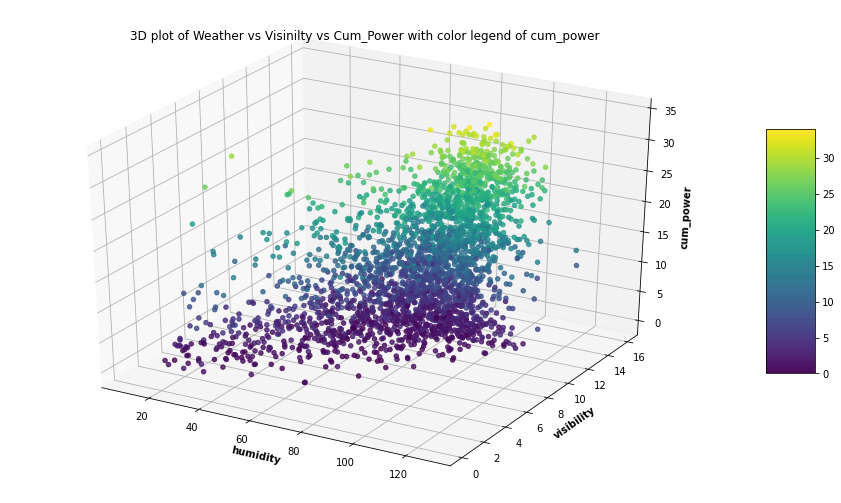

In [ ]:
# Creating figure 
fig = plt.figure(figsize = (16, 9)) 
ax = plt.axes(projection ="3d")

# Add x, y gridlines  
ax.grid(b = True, color ='grey',  
        linestyle ='-.', linewidth = 0.3,  
        alpha = 0.2)  
  
# Creating color map 
my_cmap = plt.get_cmap('hsv') 
  
# Creating plot 
sctt = ax.scatter3D(df['weather'], df['visibility'], df['cum_power'], 
                    alpha = 0.8, 
                    c = df['cum_power']) 
  
plt.title('3D plot of Weather vs Visinilty vs Cum_Power with color legend of cum_power') 
ax.set_xlabel('humidity', fontweight ='bold')  
ax.set_ylabel('visibility', fontweight ='bold')  
ax.set_zlabel('cum_power', fontweight ='bold') 
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5) 
  
# show plot 
plt.show() 

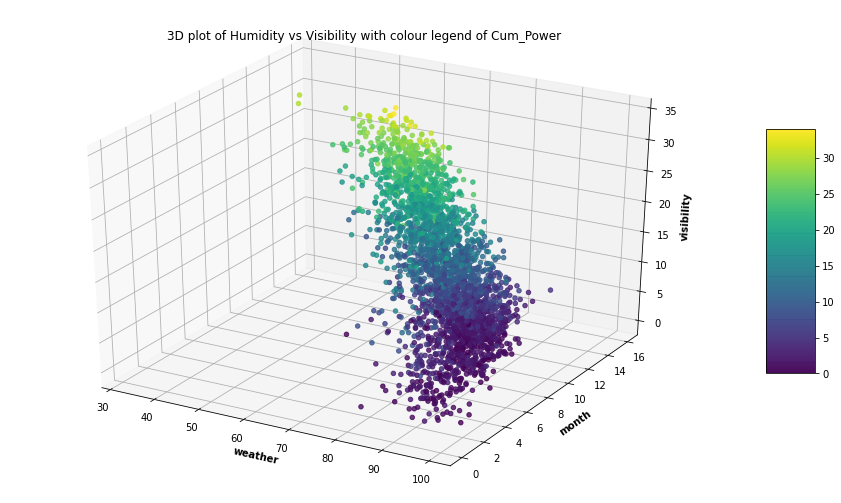

In [ ]:
# Creating figure 
fig = plt.figure(figsize = (16, 9)) 
ax = plt.axes(projection ="3d")

# Add x, y gridlines  
ax.grid(b = True, color ='grey',  
        linestyle ='-.', linewidth = 0.3,  
        alpha = 0.2)  
  
# Creating color map 
my_cmap = plt.get_cmap('hsv') 
  
# Creating plot 
sctt = ax.scatter3D(df['humidity'], df['visibility'], df['cum_power'], 
                    alpha = 0.8, 
                    c = df['cum_power']) 
  
plt.title('3D plot of Humidity vs Visibility with colour legend of Cum_Power') 
ax.set_xlabel('weather', fontweight ='bold')  
ax.set_ylabel('month', fontweight ='bold')  
ax.set_zlabel('visibility', fontweight ='bold') 
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5) 
  
# show plot 
plt.show() 

# **MODEL DEVELOPMENT AND TRAINING**

In [ ]:
y = df[['cum_power']]
xt = df[['year','month','day','temp','weather','wind','humidity','barometer','visibility']] 

scaler = StandardScaler()
x = scaler.fit_transform(xt)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=42)

In [ ]:
def rmse_test(model, X=xtrain):
    rmse = np.sqrt(-cross_val_score(model, xtrain, ytrain, scoring="neg_mean_squared_error", cv=5))
    return (rmse)

## **LASSO CV**

In [ ]:
lasso = LassoCV(random_state=42, cv=5)

In [ ]:
print("RMSE score for Lasso:")
print(rmse_test(lasso).mean())

RMSE score for Lasso:


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expec

4.378881381967078


In [ ]:
lasso_model = lasso.fit(xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
ypred = lasso_model.predict(xtest)
np.sqrt(mean_squared_error(ytest, ypred))

4.425913014231911

## **ELASTIC NET**

In [ ]:
elastic_net = ElasticNetCV(random_state=42, cv=5)

In [ ]:
print("RMSE score for Elastic Net:")
print(rmse_test(elastic_net).mean())

RMSE score for Elastic Net:


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4.379462384070935


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
elastic_model = elastic_net.fit(xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
ypred = elastic_model.predict(xtest)
np.sqrt(mean_squared_error(ytest, ypred))

4.423556549163323

## **RANDOM FOREST**

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
print("RMSE score for Random Forest:")
print(rmse_test(rf).mean())

RMSE score for Random Forest:


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

3.7935465803815873


In [ ]:
rf_model = rf.fit(xtrain,ytrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [ ]:
ypred = rf_model.predict(xtest)
np.sqrt(mean_squared_error(ytest, ypred))

3.7556473272916486

## **XGBOOST**

In [ ]:
xgboost = XGBRegressor(random_state=42)

In [ ]:
print("RMSE score for XGBoost:")
print(rmse_test(xgboost).mean())

RMSE score for XGBoost:
[11:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3.7209273224736585


In [ ]:
xgb_model = xgboost.fit(xtrain, ytrain)

[11:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
ypred = xgb_model.predict(xtest)
np.sqrt(mean_squared_error(ytest, ypred))

3.7327876533801634

## **HPERPARAMETER TUNING ON BEST PERFORMING MODEL**

In [ ]:
xgboost = XGBRegressor(learning_rate=0.1,n_estimators=200,random_state=42)

In [ ]:
xgboost.t

In [ ]:
print("RMSE score for XGBoost:")
print(rmse_test(xgboost).mean())

RMSE score for XGBoost:
[13:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3.7127939475745393


In [ ]:
xgb_model = xgboost.fit(xtrain, ytrain)

[13:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
ypred = xgb_model.predict(xtest)
np.sqrt(mean_squared_error(ytest, ypred))

3.7201044858778967

## **SAVE MODEL**

In [ ]:
xgb_model.save_model('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/xgbmodel.json')

In [ ]:
model = Booster().save_model('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/xgbmodelbooster.json')

In [ ]:
model.predict(78)

In [ ]:
# SAVE MODEL
pickle.dump(xgb_model, open('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/xgbmodel.json','wb'))

In [ ]:
Booster().save_model('xgbmodel.json')

In [ ]:
import joblib
#save model
joblib.dump(xgboost, '/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/xgbmodel1.json') 

['/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/xgbmodel1.json']

# **MODEL EVALUATION**

In [ ]:
xgb_model.feature_importances_

array([0.01372511, 0.17062217, 0.01521368, 0.13265085, 0.01316743,
       0.03125056, 0.5824643 , 0.02757511, 0.01333083], dtype=float32)

In [ ]:
features = np.reshape(xgb_model.feature_importances_,(1,9))
featuredf = pd.DataFrame(features,columns=xt.columns)

In [ ]:
# FEATURE COEEFICIENTS
featuredf.head()

,year,month,day,temp,weather,wind,humidity,barometer,visibility
0,0.013725,0.170622,0.015214,0.132651,0.013167,0.031251,0.582464,0.027575,0.013331


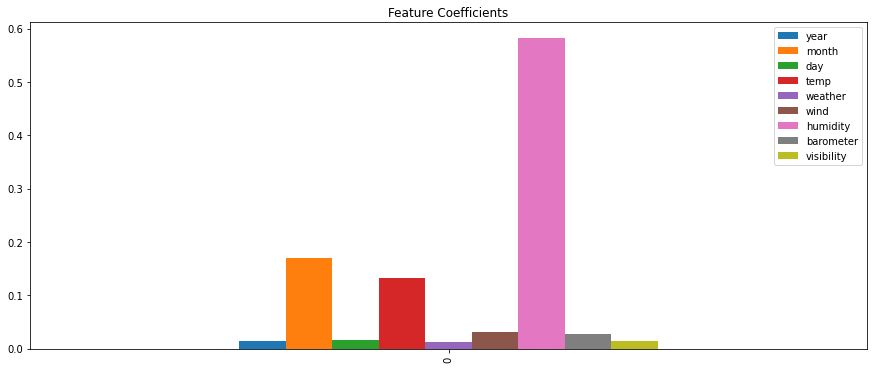

In [ ]:
featuredf.plot(kind='bar',title='Feature Coefficients',figsize=(15,6))

In [ ]:
# RESIDUAL PLOT
from yellowbrick.regressor import ResidualsPlot

model = xgb_model
visualizer = ResidualsPlot(model)

visualizer.fit(xtrain, np.reshape(ytrain.values, (1,-1)))  # Fit the training data to the visualizer
visualizer.score(xtest, np.reshape(ytest.values, (1,-1)))  # Evaluate the model on the test data
visualizer

In [ ]:
model = pickle.load(open('/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/xgbmodel.pkl', 'rb'))

[16:52:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# **MODEL DEVELOPMENT WITH PYCARET**

In [ ]:
from pycaret.regression import *

In [ ]:
setup = setup(df, target = 'cum_power', session_id = 123, normalize = True,
              numeric_features = ['year','month','day','temp','weather','wind','humidity','barometer','visibility'],
              polynomial_features = True, trigonometry_features = True, feature_interaction=True,
              bin_numeric_features = ['weather'])

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2824, 10)"
4,Missing Values,False
5,Numeric Features,9
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
setup[0].columns

Index(['year', 'month', 'day', 'temp', 'wind', 'humidity', 'barometer',
       'visibility', 'humidity_Power2', 'wind_Power2', 'month_Power2',
       'visibility_Power2', 'temp_Power2', 'weather_Power2', 'weather_0.0',
       'weather_1.0', 'weather_10.0', 'weather_11.0', 'weather_12.0',
       'weather_2.0', 'weather_3.0', 'weather_4.0', 'weather_5.0',
       'weather_6.0', 'weather_7.0', 'weather_8.0', 'weather_9.0',
       'wind_Power2_multiply_humidity_Power2',
       'humidity_Power2_multiply_humidity', 'month_Power2_multiply_month',
       'weather_Power2_multiply_wind', 'month_Power2_multiply_humidity',
       'temp_Power2_multiply_humidity_Power2', 'month_Power2_multiply_temp',
       'day_multiply_month', 'temp_Power2_multiply_humidity',
       'weather_8.0_multiply_humidity', 'weather_8.0_multiply_humidity_Power2',
       'month_multiply_month_Power2'],
      dtype='object')

In [ ]:
regressor = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.5146,10.4174,3.2276,0.8323,0.3835,0.3680
1,2.8261,13.1649,3.6284,0.7952,0.4319,0.5219
2,2.6419,12.3481,3.5140,0.8056,0.3665,0.4546
3,3.0141,15.7580,3.9696,0.7584,0.3565,0.3921
4,2.7352,12.6230,3.5529,0.8280,0.3574,0.4347
5,2.8242,13.2584,3.6412,0.8024,0.3953,0.4577
6,2.8213,13.4682,3.6699,0.8032,0.3673,0.4732
7,2.7320,12.5935,3.5487,0.8280,0.3786,0.4110
8,2.7190,12.8798,3.5888,0.8009,0.3196,0.3732
9,2.5496,12.9270,3.5954,0.7956,0.3726,0.4058


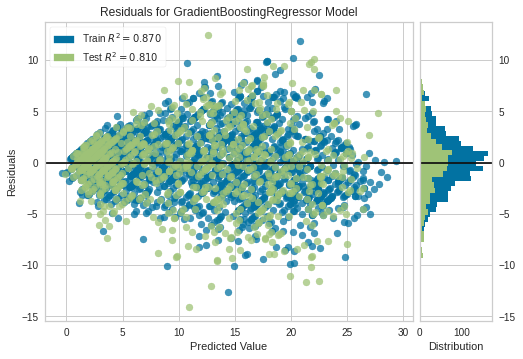

In [ ]:
plot_model(regressor)

In [ ]:
save_model(regressor, '/content/drive/My Drive/Deployment Models/Solar Energy Belgium/Solar Energy in Antwerp/deployment_1')

Transformation Pipeline and Model Succesfully Saved
